remove some bad areas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import preproc_RNN_LSTM
import pandas as pd
import plot_evaluate_models
import matplotlib.pyplot as plt
from metrics import get_baseline_data
import numpy as np
import math
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from baseline import get_baseline_actual, get_baseline_predictions, forecast_accuracy

# Import imput data

In [40]:
data = preproc_RNN_LSTM.get_baseline_data("raw_data/preproc_data_rate.csv")

## Remove regions with poor records

remove: complexo do aleamao, Jacarezinho, Rocinha


In [41]:
data.drop(columns=["Complexo do Alemao","Jacarezinho", "Rocinha", "Mare"], inplace=True)

In [42]:
data.head()

,Date,Anchieta,Bangu,Barra da Tijuca,Botafogo,Campo Grande,Centro,Cidade de Deus,Copacabana,Guaratiba,...,Pavuna,Portuaria,Ramos,Realengo,Rio Comprido,Santa Cruz,Santa Teresa,Sao Cristovao,Tijuca,Vila Isabel
0,2008-12-31,0.025522,0.009079,0.011007,0.000000,0.010674,0.066617,0.000000,0.034691,0.050378,...,0.005001,0.000000,0.006877,0.026449,0.015969,0.002863,0.057947,0.052674,0.006297,0.000000
1,2009-01-01,0.063703,0.047398,0.052289,0.057072,0.066402,0.103458,0.198661,0.070387,0.083396,...,0.044931,0.029703,0.062168,0.046459,0.114169,0.062111,0.000000,0.072225,0.012807,0.053311
2,2009-01-02,0.031852,0.015799,0.010458,0.009512,0.045433,0.206917,0.000000,0.056310,0.015163,...,0.014977,0.000000,0.034538,0.025811,0.016310,0.028232,0.192864,0.018056,0.025613,0.038079
3,2009-01-03,0.006370,0.040626,0.017430,0.014268,0.027959,0.103458,0.198661,0.042232,0.037907,...,0.029954,0.059406,0.041445,0.041297,0.048929,0.014116,0.096432,0.054169,0.019210,0.015232
4,2009-01-04,0.006370,0.029341,0.006972,0.014268,0.033201,0.206917,0.099331,0.035194,0.015163,...,0.029954,0.000000,0.034538,0.036135,0.114169,0.042349,0.000000,0.126394,0.012807,0.007616


# Set parameters

In [43]:
n_sequences=4000
length=100
prediction_horizon = 31

# Modelling

## set training and test set

In [44]:
X_train, y_train, X_test, y_test = preproc_RNN_LSTM.get_train_test(data,n_sequences,length, prediction_horizon)

In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 69, 26), (4000, 31, 26), (1000, 69, 26), (1000, 31, 26))

## define model

In [48]:
#model1 = preproc_RNN_LSTM.model(n_sequences, length-prediction_horizon, 30, prediction_horizon)

model1 = models.Sequential()
model1.add(layers.LSTM(128, return_sequences=False, activation="tanh", \
    input_shape = (length-prediction_horizon, 26)))
model1.add(layers.RepeatVector(prediction_horizon))
#model.add(Dropout(0.4))
model1.add(layers.LSTM(40, return_sequences=True, activation="tanh"))
# added 
#model.add(BatchNormalization())
#model.add(Dropout(0.4))
model1.add(layers.TimeDistributed(layers.Dense(26,"relu")))
model1.compile(loss="mse",
            optimizer="rmsprop")

## train model

In [49]:
#preproc_RNN_LSTM.fit_model(X_train, y_train, model1)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)
hist = model1.fit(X_train, y_train, 
                 callbacks=[es],
                 epochs = 2000,
                 validation_split =0.3, 
                 batch_size=16
                )

Epoch 1/2000
175/175 [==============================] - 6s 26ms/step - loss: 0.0576 - val_loss: 0.0539
Epoch 2/2000
175/175 [==============================] - 4s 24ms/step - loss: 0.0541 - val_loss: 0.0521
Epoch 3/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0522 - val_loss: 0.0502
Epoch 4/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0505 - val_loss: 0.0478
Epoch 5/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0488 - val_loss: 0.0477
Epoch 6/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0473 - val_loss: 0.0458
Epoch 7/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0460 - val_loss: 0.0451
Epoch 8/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0451 - val_loss: 0.0427
Epoch 9/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 10/2000
175/175 [==============================] - 4s 24ms/step - l

Epoch 80/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0249 - val_loss: 0.0291
Epoch 81/2000
175/175 [==============================] - 4s 24ms/step - loss: 0.0250 - val_loss: 0.0292
Epoch 82/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 83/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0249 - val_loss: 0.0253
Epoch 84/2000
175/175 [==============================] - 4s 24ms/step - loss: 0.0249 - val_loss: 0.0268
Epoch 85/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0244 - val_loss: 0.0247
Epoch 86/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0236 - val_loss: 0.0248
Epoch 87/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0241 - val_loss: 0.0266
Epoch 88/2000
175/175 [==============================] - 4s 23ms/step - loss: 0.0241 - val_loss: 0.0298
Epoch 89/2000
175/175 [==============================] - 4s 23ms

# Check outputs

## Check validation set

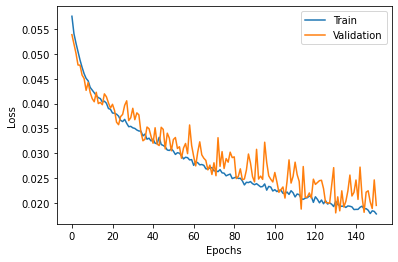

In [51]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

## Check predicted vs actual on test set

In [53]:
def compute_pred_test(data,modelname,length, prediction_horizon):
    ''' compute prediction over the full test period'''
    len_ = int(0.8*data.shape[0])
    test_data = data[len_:]
    pred = test_data.copy()
    pred.iloc[:,1:] = None

    for i in range(0,804-(length-prediction_horizon)-prediction_horizon,prediction_horizon):
        pred_one = modelname.predict(test_data.iloc[i:i+(length-prediction_horizon),1:]\
            .to_numpy().reshape(1,(length-prediction_horizon),26))[0]
        #model.predict()
        pred.iloc[i+(length-prediction_horizon):i+(length-prediction_horizon)\
            +prediction_horizon,1:] = pred_one

    return pred

In [54]:
y_pred = compute_pred_test(data,model1,length, prediction_horizon)

In [55]:
def plot_actual_pred_test(data,modelname, length, prediction_horizon):
    '''plot pred VS actual VS baseline'''
    regions = ['Anchieta','Bangu','Barra da Tijuca','Botafogo','Campo Grande','Centro',\
           'Cidade de Deus','Copacabana','Guaratiba','Ilha do Governador',\
           'Inhauma','Iraja','Jacarepagua','Lagoa','Madureira','Meier','Pavuna',\
           'Portuaria','Ramos','Realengo','Rio Comprido','Santa Cruz','Santa Teresa','Sao Cristovao',\
           'Tijuca','Vila Isabel']
    len_ = int(0.8*data.shape[0])
    test_data = data[len_:]
    baseline = get_baseline_predictions(data)
    y_pred = compute_pred_test(data,modelname,length, prediction_horizon)
    fig, ax = plt.subplots(26,1,figsize=(16,100))
    for i,AR in enumerate(regions):
            ax[i].plot(test_data.iloc[length-prediction_horizon:,0],test_data.iloc[length-prediction_horizon:,i+1], c= "blue", label='actual')
            ax[i].plot(test_data.iloc[length-prediction_horizon:,0],y_pred.iloc[length-prediction_horizon:,i+1], c="red", label = "forecast")
            ax[i].plot(test_data.iloc[length-prediction_horizon:,0], baseline.iloc[length-prediction_horizon:,i], c="green", linestyle='dashed', label = "baseline")
            ax[i].title.set_text(AR)
            ax[i].legend(loc="upper left")

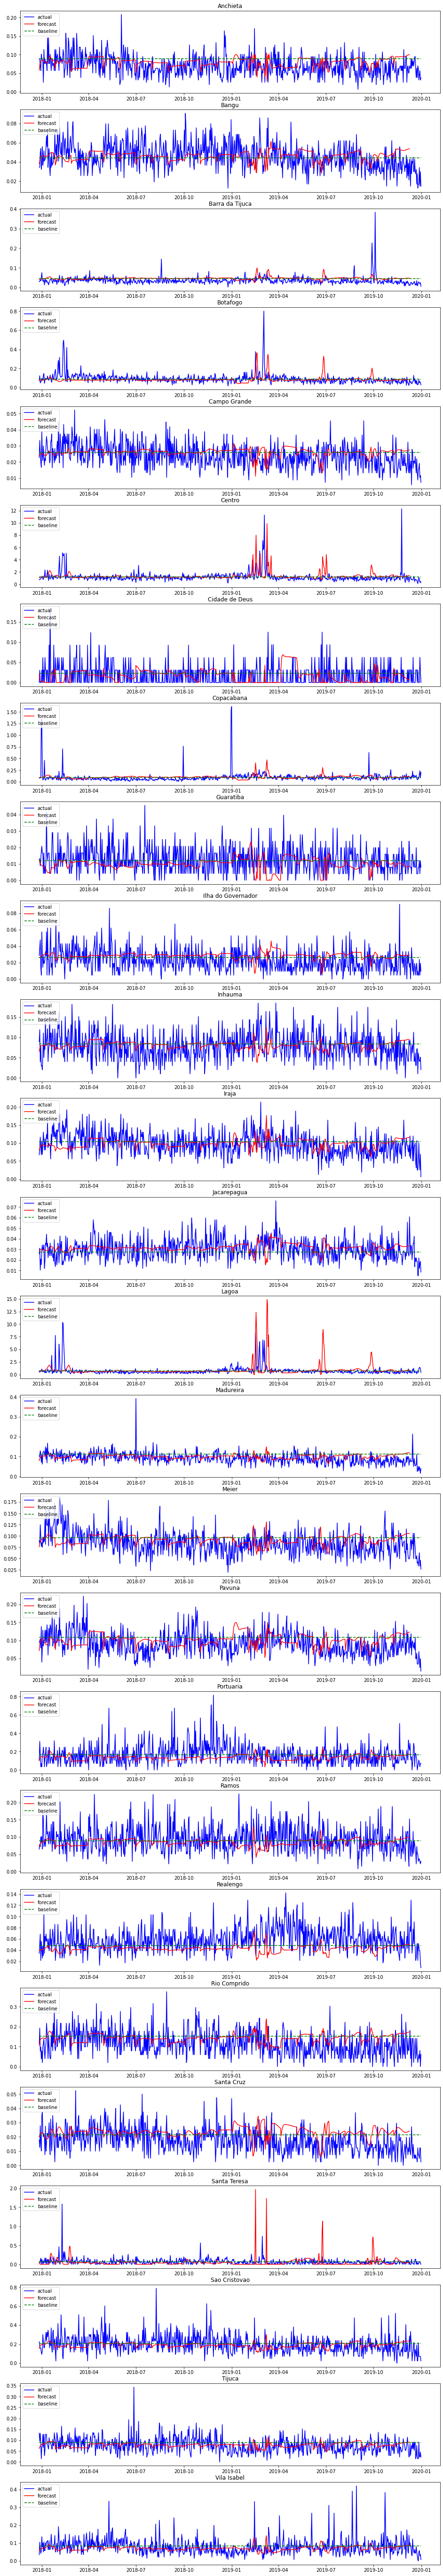

In [56]:
plot_actual_pred_test(data,model1, length, prediction_horizon)

In [57]:
error = plot_evaluate_models.error_actual_pred_baseline(data,y_pred,length, prediction_horizon)

/Users/desireepetrilli/Documents/event-forecast-rio/baseline.py:19: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  baseline_mean = baseline_data.mean().to_frame().T


In [58]:
error

,mae_baseline,mae_prediction
Anchieta,0.027359,0.024420
Bangu,0.010589,0.011177
Barra da Tijuca,0.014586,0.015973
Botafogo,0.028518,0.033613
Campo Grande,0.006256,0.006377
Centro,0.402029,0.499865
Cidade de Deus,0.021297,0.022428
Copacabana,0.042601,0.053786
Guaratiba,0.006022,0.006795
Ilha do Governador,0.010885,0.012240


In [61]:
baseline

NameError: name 'baseline' is not defined